In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sodapy import Socrata
import datetime

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, lit, udf

In [2]:
from secop.pipelines.data_engineering.utilities import _remove_tildes

In [3]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
secop_2 = catalog.load("secop_2@pandas")

                    INFO     Loading data from 'secop_2@pandas' (ParquetDataSetSecop)...        ]8;id=157102;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=355170;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

<IPython.core.display.Javascript object>

In [5]:
secop_2.columns

Index(['entidad', 'departamento_entidad', 'ciudad_entidad', 'ordenentidad',
       'id_del_proceso', 'referencia_del_proceso', 'nombre_del_procedimiento',
       'descripci_n_del_procedimiento', 'fase', 'precio_base',
       'modalidad_de_contratacion', 'duracion', 'unidad_de_duracion',
       'proveedores_invitados', 'proveedores_con_invitacion',
       'visualizaciones_del', 'proveedores_que_manifestaron',
       'respuestas_al_procedimiento', 'respuestas_externas',
       'conteo_de_respuestas_a_ofertas', 'proveedores_unicos_con',
       'estado_del_procedimiento', 'adjudicado', 'departamento_proveedor',
       'ciudad_proveedor', 'valor_total_adjudicacion',
       'nombre_del_adjudicador', 'nombre_del_proveedor',
       'nit_del_proveedor_adjudicado', 'tipo_de_contrato',
       'subtipo_de_contrato', 'fecha_de_publicacion_del',
       'fecha_de_ultima_publicaci', 'fecha_de_publicacion_fase_3',
       'fecha_de_recepcion_de', 'fecha_de_apertura_efectiva', 'nit_entidad'],
      dtype='object')

<IPython.core.display.Javascript object>

In [6]:
secop_2["nit_entidad"] = (
    secop_2["nit_entidad"]
    .astype(int)
    .apply(lambda x: int(np.floor(x / 10)) if x >= 1000000000 else x)
)

<IPython.core.display.Javascript object>

In [7]:
cols_tildes_lower = [
    "entidad",
    "departamento_entidad",
    "ciudad_entidad",
    "ordenentidad",
    "fase",
    "modalidad_de_contratacion",
    "unidad_de_duracion",
    "estado_del_procedimiento",
    "adjudicado",
    "departamento_proveedor",
    "ciudad_proveedor",
    "nombre_del_adjudicador",
    "nombre_del_proveedor",
    "tipo_de_contrato",
    "subtipo_de_contrato",
]

<IPython.core.display.Javascript object>

In [8]:
secop_2[cols_tildes_lower] = (
    secop_2[cols_tildes_lower].applymap(lambda x: _remove_tildes(x.lower())).values
)

<IPython.core.display.Javascript object>

In [9]:
secop_2 = secop_2[
    secop_2["modalidad_de_contratacion"] != "solicitud de informacion a los proveedores"
].copy()

<IPython.core.display.Javascript object>

In [10]:
def _clean_modalidad_contratacion_2(mod: str):
    """Clean and group modalidad de contratación for SECOP II"""
    if "concurso" in mod:
        return "concurso meritos"
    elif "licitacion" in mod:
        return "licitacion publica"
    elif "cuantia" in mod:
        return "menor cuantia"
    elif "contratacion directa" in mod:
        return "contratacion directa"
    elif "regimen especial" in mod:
        return "regimen especial"
    elif "subasta" in mod:
        return "subasta"
    else:
        return "otro"

<IPython.core.display.Javascript object>

In [11]:
secop_2["modalidad_de_contratacion"] = secop_2["modalidad_de_contratacion"].apply(
    _clean_modalidad_contratacion_2
)

<IPython.core.display.Javascript object>

In [12]:
for c in [
    "proveedores_invitados",
    "proveedores_con_invitacion",
    "visualizaciones_del",
    "proveedores_que_manifestaron",
    "respuestas_al_procedimiento",
    "respuestas_externas",
    "conteo_de_respuestas_a_ofertas",
    "proveedores_unicos_con",
    "duracion",
    "valor_total_adjudicacion",
]:
    secop_2[c] = secop_2[c].astype(int)

<IPython.core.display.Javascript object>

In [13]:
map_duracion = {"dias": 1, "meses": 30, "años": 365, "nd": 0}
secop_2["duracion_dias"] = secop_2[["duracion", "unidad_de_duracion"]].apply(
    lambda row: row["duracion"] * map_duracion[row["unidad_de_duracion"]], axis=1
)

<IPython.core.display.Javascript object>

In [14]:
secop_2.drop(["duracion", "unidad_de_duracion", "adjudicado"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [19]:
secop_2["nit_del_proveedor_adjudicado"] = (
    secop_2["nit_del_proveedor_adjudicado"]
    .replace("No Adjudicado", 0)
    .replace("No Definido", 0)
)

<IPython.core.display.Javascript object>

In [30]:
secop_2["tipo_de_contrato"].value_counts()

servicios de aprovisionamiento    1412902
suministros                         86842
27 - otros servicios                84632
decreto 092 de 2017                 74800
compraventa                         70621
obra                                29352
alquiler de edificios               15541
interventoria                        8315
consultoria                          7300
nd                                   6278
seguros                              5161
arrendamiento muebles                1345
acuerdo marco                        1107
ventas de muebles                     237
concesion                             170
comision                              133
no especificado                        27
Name: tipo_de_contrato, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
secop_2["adjudicado"].value_counts()

no    1571736
si     233027
Name: adjudicado, dtype: int64

<IPython.core.display.Javascript object>

In [21]:
secop_2["valor_total_adjudicacion"].astype(int)

0                 0
1                 0
4                 0
5                 0
6                 0
             ...   
1861368     1195901
1861369           0
1861370           0
1861371           0
1861372    84884090
Name: valor_total_adjudicacion, Length: 1804763, dtype: int64

<IPython.core.display.Javascript object>

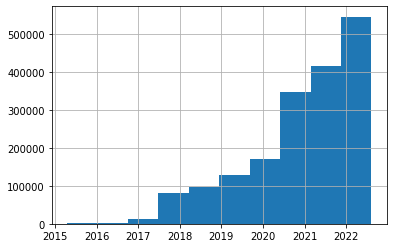

<IPython.core.display.Javascript object>

In [19]:
secop_2["fecha_de_publicacion_del"].hist()

In [83]:
secop_2["fase"].value_counts()

presentacion de oferta                             1764387
presentacion de observaciones                        53385
manifestacion de interes (menor cuantia)             21945
fase de ofertas                                      15222
fase de seleccion (presentacion de ofertas)           3685
no definido                                           1719
clarification submission                               425
estimate phase                                         285
pre-calificacion de competidores                       225
proceso de ofertas                                      67
seleccion de ofertas (borrador)                         23
presentacion de observaciones (precalificacion)          3
presentacion de oferta (precalificacion)                 2
Name: fase, dtype: int64

<IPython.core.display.Javascript object>

In [84]:
secop_2.columns

Index(['entidad', 'departamento_entidad', 'ciudad_entidad', 'ordenentidad',
       'id_del_proceso', 'referencia_del_proceso', 'nombre_del_procedimiento',
       'descripci_n_del_procedimiento', 'fase', 'precio_base',
       'modalidad_de_contratacion', 'duracion', 'unidad_de_duracion',
       'proveedores_invitados', 'proveedores_con_invitacion',
       'visualizaciones_del', 'proveedores_que_manifestaron',
       'respuestas_al_procedimiento', 'respuestas_externas',
       'conteo_de_respuestas_a_ofertas', 'proveedores_unicos_con',
       'estado_del_procedimiento', 'adjudicado', 'departamento_proveedor',
       'ciudad_proveedor', 'valor_total_adjudicacion',
       'nombre_del_adjudicador', 'nombre_del_proveedor',
       'nit_del_proveedor_adjudicado', 'tipo_de_contrato',
       'subtipo_de_contrato', 'fecha_de_publicacion_del',
       'fecha_de_ultima_publicaci', 'fecha_de_publicacion_fase_3',
       'fecha_de_recepcion_de', 'fecha_de_apertura_efectiva', 'nit_entidad'],
      dtype='object')

<IPython.core.display.Javascript object>

In [71]:
secop_2['entidad'].apply()

,entidad,departamento_entidad,ciudad_entidad,ordenentidad,id_del_proceso,referencia_del_proceso,nombre_del_procedimiento,descripci_n_del_procedimiento,fase,precio_base,...,nombre_del_proveedor,nit_del_proveedor_adjudicado,tipo_de_contrato,subtipo_de_contrato,fecha_de_publicacion_del,fecha_de_ultima_publicaci,fecha_de_publicacion_fase_3,fecha_de_recepcion_de,fecha_de_apertura_efectiva,nit_entidad
0,Vortal Operations,Quindío,Armenia,Territorial,CO1.REQ.948804,CMA_MFR_2808_2,CMAMFR2808,CMAMFR2808,No Definido,-1,...,No Adjudicado,No Adjudicado,Consultoría,No Especificado,None,None,None,None,None,1
1,Vortal Operations,Quindío,Armenia,Territorial,CO1.REQ.948433,CMA_MFR_2808,CMAMFR2808,CMAMFR2808,No Definido,-1,...,No Adjudicado,No Adjudicado,Consultoría,No Especificado,None,None,None,None,None,1
2,Vortal Operations,Quindío,Armenia,Territorial,CO1.REQ.1992464,SIP_2604,SIP2604,SIP2604,Estimate Phase,-1,...,No Adjudicado,No Adjudicado,ND,No Especificado,2021-04-26,2021-04-26,2021-04-26,2021-04-30,2021-04-26,1
3,Vortal Operations,Quindío,Armenia,Territorial,CO1.REQ.1994804,SIP_2604 Copy,SIP2604 Copy,SIP2604,Estimate Phase,-1,...,No Adjudicado,No Adjudicado,ND,No Especificado,2021-04-27,2021-04-27,2021-04-27,2021-04-30,2021-04-27,1
4,SECRETARÍA DISTRITAL DE CULTURA RECREACIÓN Y D...,Distrito Capital de Bogotá,Bogotá,Territorial,CO1.REQ.742030,ESDOP 118 de 2019,Apoyar el proceso de acompañamiento metodológi...,Prestar los servicios profesionales para apoya...,No Definido,66374000,...,No Adjudicado,No Adjudicado,Servicios de aprovisionamiento,No Especificado,None,None,None,None,None,899999061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861368,PERSONERIA MUNICIPAL DE SANTA ROSALIA VICHADA,Vichada,Santa Rosalía,Territorial,CO1.REQ.2829203,03,ADQUISICIÓN DE SEGURO PÓLIZA MULTIRIESGOS QUE ...,ADQUISICIÓN DE SEGURO PÓLIZA MULTIRIESGOS QUE ...,Presentación de oferta,1200000,...,LA PREVISORA SA COMPAÑÍA DE SEGUROS,860002400,Seguros,No Especificado,2022-02-03,2022-02-03,2022-02-03,2022-02-09,2022-02-09,901552719
1861369,PERSONERIA MUNICIPAL DE SANTA ROSALIA VICHADA,Vichada,Santa Rosalía,Territorial,CO1.REQ.2650955,01,PRESTACIÓN DE SERVICIOS PROFESIONALES PARA LA ...,PRESTACIÓN DE SERVICIOS PROFESIONALES PARA LA ...,Presentación de oferta,10000000,...,No Adjudicado,No Adjudicado,Servicios de aprovisionamiento,No Especificado,2022-01-18,2022-01-18,2022-01-18,None,None,901552719
1861370,PERSONERIA MUNICIPAL DE SANTA ROSALIA VICHADA,Vichada,Santa Rosalía,Territorial,CO1.REQ.2698653,02,PRESTACIÓN DE SERVICIOS DE APOYO A LA GESTIÓN ...,,Presentación de oferta,4400000,...,No Adjudicado,No Adjudicado,Servicios de aprovisionamiento,No Especificado,2022-01-20,2022-01-20,2022-01-20,None,None,901552719
1861371,ALUMBRADO PUBLICO DE YUMBO SEM SAS,Valle del Cauca,Yumbo,Territorial,CO1.REQ.3104135,CONCURSO DE MERITOS No. 001 DE 2022,REALIZAR LA INTERVENTORIA A LA PRESTACIÓN DEL ...,REALIZAR LA INTERVENTORIA A LA PRESTACIÓN DEL ...,Presentación de observaciones,84884090,...,No Adjudicado,No Adjudicado,Interventoría,No Especificado,2022-07-11,2022-07-11,None,2022-07-27,2022-07-27,901554184


<IPython.core.display.Javascript object>

In [69]:
secop_2["nit_entidad"].max()

901554184

<IPython.core.display.Javascript object>

In [70]:
secop_2["nit_entidad"].min()

1

<IPython.core.display.Javascript object>

In [ ]:
x/10

In [5]:
secop_2.cache()

22/08/11 19:40:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[entidad: string, departamento_entidad: string, ciudad_entidad: string, ordenentidad: string, id_del_proceso: string, referencia_del_proceso: string, nombre_del_procedimiento: string, descripci_n_del_procedimiento: string, fase: string, precio_base: string, modalidad_de_contratacion: string, duracion: string, unidad_de_duracion: string, proveedores_invitados: string, proveedores_con_invitacion: string, visualizaciones_del: string, proveedores_que_manifestaron: string, respuestas_al_procedimiento: string, respuestas_externas: string, conteo_de_respuestas_a_ofertas: string, proveedores_unicos_con: string, estado_del_procedimiento: string, adjudicado: string, departamento_proveedor: string, ciudad_proveedor: string, valor_total_adjudicacion: string, nombre_del_adjudicador: string, nombre_del_proveedor: string, nit_del_proveedor_adjudicado: string, tipo_de_contrato: string, subtipo_de_contrato: string, fecha_de_publicacion_del: date, fecha_de_ultima_publicaci: date, fecha_de_publicacion_fase_3: date, fecha_de_recepcion_de: date, fecha_de_apertura_efectiva: date, nit_entidad: bigint]

<IPython.core.display.Javascript object>

In [ ]:
secop_2_df = secop_2.toPandas()

In [16]:
columnList = [item[0] for item in secop_2.dtypes if item[1].startswith("string")]

<IPython.core.display.Javascript object>

In [17]:
columnList

[
    'entidad',
    'departamento_entidad',
    'ciudad_entidad',
    'ordenentidad',
    'codigo_pci',
    'id_del_proceso',
    'referencia_del_proceso',
    'ppi',
    'nombre_del_procedimiento',
    'descripci_n_del_procedimiento',
    'fase',
    'precio_base',
    'modalidad_de_contratacion',
    'duracion',
    'unidad_de_duracion',
    'ciudad_de_la_unidad_de',
    'nombre_de_la_unidad_de',
    'proveedores_invitados',
    'proveedores_con_invitacion',
    'visualizaciones_del',
    'proveedores_que_manifestaron',
    'respuestas_al_procedimiento',
    'respuestas_externas',
    'conteo_de_respuestas_a_ofertas',
    'proveedores_unicos_con',
    'estado_del_procedimiento',
    'id_estado_del_procedimiento',
    'adjudicado',
    'id_adjudicacion',
    'codigoproveedor',
    'departamento_proveedor',
    'ciudad_proveedor',
    'valor_total_adjudicacion',
    'nombre_del_adjudicador',
    'nombre_del_proveedor',
    'nit_del_proveedor_adjudicado',
    'codigo_principal_de_categoria',
    'estado_de_apertura_del_proceso',
    'tipo_de_contrato',
    'subtipo_de_contrato',
    'categorias_adicionales',
    'codigo_entidad',
    'estadoresumen',
    'fecha_de_publicacion_del',
    'fecha_de_ultima_publicaci',
    'fecha_de_publicacion_fase_3',
    'fecha_de_recepcion_de',
    'fecha_de_apertura_efectiva'
]

<IPython.core.display.Javascript object>

In [15]:
secop_2.schema

StructType(List(StructField(entidad,StringType,true),StructField(departamento_entidad,StringType,true),StructField(ciudad_entidad,StringType,true),StructField(ordenentidad,StringType,true),StructField(codigo_pci,StringType,true),StructField(id_del_proceso,StringType,true),StructField(referencia_del_proceso,StringType,true),StructField(ppi,StringType,true),StructField(nombre_del_procedimiento,StringType,true),StructField(descripci_n_del_procedimiento,StringType,true),StructField(fase,StringType,true),StructField(precio_base,StringType,true),StructField(modalidad_de_contratacion,StringType,true),StructField(duracion,StringType,true),StructField(unidad_de_duracion,StringType,true),StructField(ciudad_de_la_unidad_de,StringType,true),StructField(nombre_de_la_unidad_de,StringType,true),StructField(proveedores_invitados,StringType,true),StructField(proveedores_con_invitacion,StringType,true),StructField(visualizaciones_del,StringType,true),StructField(proveedores_que_manifestaron,StringType,true),StructField(respuestas_al_procedimiento,StringType,true),StructField(respuestas_externas,StringType,true),StructField(conteo_de_respuestas_a_ofertas,StringType,true),StructField(proveedores_unicos_con,StringType,true),StructField(estado_del_procedimiento,StringType,true),StructField(id_estado_del_procedimiento,StringType,true),StructField(adjudicado,StringType,true),StructField(id_adjudicacion,StringType,true),StructField(codigoproveedor,StringType,true),StructField(departamento_proveedor,StringType,true),StructField(ciudad_proveedor,StringType,true),StructField(valor_total_adjudicacion,StringType,true),StructField(nombre_del_adjudicador,StringType,true),StructField(nombre_del_proveedor,StringType,true),StructField(nit_del_proveedor_adjudicado,StringType,true),StructField(codigo_principal_de_categoria,StringType,true),StructField(estado_de_apertura_del_proceso,StringType,true),StructField(tipo_de_contrato,StringType,true),StructField(subtipo_de_contrato,StringType,true),StructField(categorias_adicionales,StringType,true),StructField(codigo_entidad,StringType,true),StructField(estadoresumen,StringType,true),StructField(fecha_de_publicacion_del,StringType,true),StructField(fecha_de_ultima_publicaci,StringType,true),StructField(fecha_de_publicacion_fase_3,StringType,true),StructField(fecha_de_recepcion_de,StringType,true),StructField(fecha_de_apertura_efectiva,StringType,true),StructField(nit_entidad,LongType,true)))

<IPython.core.display.Javascript object>

In [13]:
secop_2.groupBy("entidad").count().show(20)

+--------------------+-----+
|             entidad|count|
+--------------------+-----+
|FONDO FINANCIERO ...| 8215|
|INSTITUTO NACIONA...|11008|
|ALCALDIA MUNICIPA...|10610|
|GOBIERNO DEPARTAM...| 8304|
|FONDO UNICO DE TE...| 6411|
|Gobernación Norte...| 6349|
|INSTITUTO TECNOLO...| 7473|
|GOBERNACION DE NA...| 5221|
|SIC SUPERINTENDEN...| 7988|
|GOBERNACION DEL H...| 4702|
|FONDO ROTATORIO D...|  571|
|DEFENSORÍA DEL PU...| 5243|
|MUNICIPIO DE SINC...| 5795|
|FONDO ROTATORIO D...|  493|
|FONDANE  DIRECCIO...| 3232|
|FONDO ROTATORIO D...| 2441|
|FONDANE  DIR TER ...|  648|
|DIRECCION DE IMPU...| 2651|
|SUPERINTENDENCIA ...| 3665|
|GOBERNACIÓN DEPAR...| 4164|
+--------------------+-----+
only showing top 20 rows



<IPython.core.display.Javascript object>

In [7]:
secop_int = secop_int.withColumn("nivel_entidad", F.lower(col("nivel_entidad")))

<IPython.core.display.Javascript object>

In [8]:
secop_int.groupBy("nivel_entidad").count().show()

+-------------+------+
|nivel_entidad| count|
+-------------+------+
|  no definido| 24448|
|     nacional| 31294|
|  territorial|711881|
+-------------+------+



<IPython.core.display.Javascript object>

In [9]:
secop_int = secop_int.withColumn(
    "estado_del_proceso", udf(remove_tildes)(F.lower(col("estado_del_proceso")))
)

<IPython.core.display.Javascript object>

In [10]:
count_process_state = secop_int.groupBy("estado_del_proceso").count().toPandas()
count_process_state.sort_values("count", ascending=False)

[08/10/22 15:57:08] WARNING  /opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/s ]8;id=19034;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=461162;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py#109\109]8;;\
                             ite-packages/pyspark/sql/pandas/utils.py:35: DeprecationWarning:                      
                             distutils Version classes are deprecated. Use packaging.version                       
                             instead.                                                                              
                               if LooseVersion(pandas.__version__) <                                               
                             LooseVersion(minimum_pandas_version):                                                 
                                                                                                                   

,estado_del_proceso,count
15,celebrado,387825
0,liquidado,209632
19,convocado,70435
6,en ejecucion,27603
16,terminado anormalmente despues de convocado,16690
18,terminado sin liquidar,13483
1,modificado,13266
20,adjudicado,9772
10,borrador,4373
5,terminado,3691


<IPython.core.display.Javascript object>

In [11]:
secop_int = secop_int.withColumn(
    "modalidad_de_contrataci_n",
    udf(remove_tildes)(F.lower(col("modalidad_de_contrataci_n"))),
)

<IPython.core.display.Javascript object>

In [12]:
count_process_type = secop_int.groupBy("modalidad_de_contrataci_n").count().toPandas()
count_process_type["prop"] = (
    count_process_type["count"] / count_process_type["count"].sum()
)

[08/10/22 15:57:23] WARNING  /opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/s ]8;id=791532;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=313822;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py#109\109]8;;\
                             ite-packages/pyspark/sql/pandas/utils.py:35: DeprecationWarning:                      
                             distutils Version classes are deprecated. Use packaging.version                       
                             instead.                                                                              
                               if LooseVersion(pandas.__version__) <                                               
                             LooseVersion(minimum_pandas_version):                                                 
                                                                                                                   

<IPython.core.display.Javascript object>

https://www.funcionpublica.gov.co/eva/gerentes/Modulo4/tema-2/1-modalidades.html

In [13]:
def clean_modalidad_contratacion(mod: str):
    """Clean and group modalidad de contratacion"""
    if ("concurso de meritos" in mod) or ("concurso_meritos" in mod):
        return "concurso de meritos abiertos"
    elif "regimen especial" in mod:
        return "regimen especial"
    elif ("minima cuantia" in mod) or ("menor cuantia" in mod):
        return "minima cuantia"
    elif "contratacion directa" in mod:
        return "contratacion directa"
    elif "subasta" in mod:
        return "subasta"
    elif ("licitacion publica" in mod) or ("licitacion obra publica" in mod):
        return "licitacion publica"
    else:
        return "Otro"

<IPython.core.display.Javascript object>

In [14]:
count_process_type["modalidad_clean"] = count_process_type[
    "modalidad_de_contrataci_n"
].apply(clean_modalidad_contratacion)
count_process_type

,modalidad_de_contrataci_n,count,prop,modalidad_clean
0,invitacion ofertas cooperativas o asociaciones...,37,0.000048,Otro
1,licitacion publica,10250,0.013353,licitacion publica
2,seleccion abreviada del literal h del numeral ...,118,0.000154,Otro
3,contratacion minima cuantia,157560,0.205257,minima cuantia
4,contratacion directa,50228,0.065433,contratacion directa
5,seleccion abreviada servicios de salud,203,0.000264,Otro
6,contratacion directa (con ofertas),497,0.000647,contratacion directa
7,minima cuantia,1716,0.002235,minima cuantia
8,contratacion directa menor cuantia,3418,0.004453,minima cuantia
9,subasta,8402,0.010945,subasta


<IPython.core.display.Javascript object>

In [15]:
secop_int = secop_int.withColumn(
    "modalidad_de_contrataci_n",
    udf(clean_modalidad_contratacion)(col("modalidad_de_contrataci_n")),
)

<IPython.core.display.Javascript object>

In [16]:
count_process_type_clean = (
    secop_int.groupBy("modalidad_de_contrataci_n").count().toPandas()
)
count_process_type_clean["prop"] = (
    count_process_type_clean["count"] / count_process_type_clean["count"].sum()
)
count_process_type_clean.sort_values("prop", ascending=False)

[08/10/22 15:58:35] WARNING  /opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/s ]8;id=643046;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=190068;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py#109\109]8;;\
                             ite-packages/pyspark/sql/pandas/utils.py:35: DeprecationWarning:                      
                             distutils Version classes are deprecated. Use packaging.version                       
                             instead.                                                                              
                               if LooseVersion(pandas.__version__) <                                               
                             LooseVersion(minimum_pandas_version):                                                 
                                                                                                                   

,modalidad_de_contrataci_n,count,prop
2,contratacion directa,373953,0.487157
4,minima cuantia,189242,0.246530
6,regimen especial,173875,0.226511
1,licitacion publica,12158,0.015839
5,subasta,8695,0.011327
3,concurso de meritos abiertos,7375,0.009608
0,Otro,2325,0.003029


<IPython.core.display.Javascript object>

In [17]:
secop_int = secop_int.withColumn(
    "tipo_de_contrato", udf(remove_tildes)(F.lower(col("tipo_de_contrato")))
)

<IPython.core.display.Javascript object>

In [18]:
count_process_type_cont = secop_int.groupBy("tipo_de_contrato").count().toPandas()
count_process_type_cont["prop"] = (
    count_process_type_cont["count"] / count_process_type_cont["count"].sum()
)
count_process_type_cont.sort_values("prop", ascending=False)

[08/10/22 15:58:52] WARNING  /opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/s ]8;id=366084;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=908621;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py#109\109]8;;\
                             ite-packages/pyspark/sql/pandas/utils.py:35: DeprecationWarning:                      
                             distutils Version classes are deprecated. Use packaging.version                       
                             instead.                                                                              
                               if LooseVersion(pandas.__version__) <                                               
                             LooseVersion(minimum_pandas_version):                                                 
                                                                                                                   

,tipo_de_contrato,count,prop
3,prestacion de servicios,535714,0.697887
0,suministro,97743,0.127332
13,obra,47713,0.062157
2,compraventa,33059,0.043067
11,otro tipo de contrato,25946,0.033800
15,consultoria,9446,0.012306
18,interventoria,6574,0.008564
8,arrendamiento,5891,0.007674
9,otro,1359,0.001770
17,decreelaw092/2017,1357,0.001768


<IPython.core.display.Javascript object>

In [22]:
def clean_tipo_contrato(tip: str):
    """Clean and group tipo de contrato"""
    if ("suministro" in tip) or (tip in ["compraventa", "venta muebles"]):
        return "suministro"
    elif ("arrendamiento" in tip) or ("comodato" in tip):
        return "arrendamiento"
    elif tip in [
        "servicios financieros",
        "credito",
        "fiducia",
        "seguros",
        "emprestito",
    ]:
        return "servicios financieros"
    elif tip in ["obra", "consultoria", "prestacion de servicios",'interventoria','concesion']:
        return tip
    else:
        return "Otro"

<IPython.core.display.Javascript object>

In [23]:
count_process_type_cont["tipo_de_contrato_clean"] = count_process_type_cont[
    "tipo_de_contrato"
].apply(clean_tipo_contrato)

<IPython.core.display.Javascript object>

In [24]:
count_process_type_cont

,tipo_de_contrato,count,prop,tipo_de_contrato_clean
0,suministro,97743,0.127332,suministro
1,servicios financieros,3,0.000004,servicios financieros
2,compraventa,33059,0.043067,suministro
3,prestacion de servicios,535714,0.697887,prestacion de servicios
4,concesion,311,0.000405,Otro
5,arrendamiento de inmuebles,140,0.000182,arrendamiento
6,comodato,752,0.000980,arrendamiento
7,no definido,307,0.000400,Otro
8,arrendamiento,5891,0.007674,arrendamiento
9,otro,1359,0.001770,Otro


<IPython.core.display.Javascript object>

In [18]:
count_process_type_cont["tipo_de_contrato"].unique()

array(['suministro', 'prestación de servicios', 'servicios financieros',
       'consultoría', 'compraventa', 'arrendamiento de inmuebles',
       'comodato', 'no definido', 'arrendamiento', 'concesión', 'otro',
       'crédito', 'otro tipo de contrato', 'suministros', 'interventoría',
       'obra', 'fiducia', 'arrendamiento de muebles', 'decreelaw092/2017',
       'seguros', 'acuerdo marco', 'agregación de demanda', 'emprestito',
       'asociación público privada', 'no especificado', 'venta muebles'],
      dtype=object)

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
from sodapy import Socrata
from typing import Dict
import datetime
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from secop.pipelines.data_engineering.utilities import (
    COLS_SEC_2,
    schema_secop_int,
    _get_nits_to_extract,
    _remove_tildes,
    _clean_modalidad_contratacion,
    _clean_tipo_contrato,
)
from pyspark.sql.types import StructType
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf

CODE_INTEGRATED = "rpmr-utcd"
CODE_SECOPII = "p6dx-8zbt"

In [2]:
secop_2_log = catalog.load('secop_2_log_in')

[08/11/22 17:20:57] INFO     Loading data from 'secop_2_log_in' (JSONDataSet)...                ]8;id=130045;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=560941;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [3]:
num_nits_to_extract = 3

In [6]:
spark = SparkSession.builder.getOrCreate()
sql_ctx = SQLContext(spark.sparkContext)
# Nit to extract. If all nits have been extracted then the oldest extraction is updated
nits_to_extract = _get_nits_to_extract(secop_2_log, num_nits_to_extract)
# Request
client = Socrata("www.datos.gov.co", None)
lim = 4000
offset = lim
print(f"req - {offset-lim} - {datetime.datetime.now()}")
request = client.get(
    CODE_SECOPII,
    limit=lim,
    select=", ".join(COLS_SEC_2),
    where='nit_entidad in ("' + '","'.join(nits_to_extract) + '")',
)
request_df = pd.DataFrame.from_records(request)
results_df = request_df.copy()

[08/11/22 17:21:38] WARNING  /opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/s ]8;id=548366;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=759658;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py#109\109]8;;\
                             ite-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in                  
                             3.0.0. Use SparkSession.builder.getOrCreate() instead.                                
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  Requests made without an app_token will be subject to strict throttling  ]8;id=808718;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/sodapy/socrata.py\socrata.py]8;;\:]8;id=294853;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/sodapy/socrata.py#63\63]8;;\
                             limits.                                                                               

req - 0 - 2022-08-11 17:21:38.991392


In [9]:
'678.678.678'.replace('.','')

'678678678'

In [8]:
results_df.iloc[0]

entidad                                        INSTITUCION EDUCATIVA CIUDADELA CUBA
departamento_entidad                                                      Risaralda
ciudad_entidad                                                              Pereira
ordenentidad                                                            Territorial
codigo_pci                                                                       Si
id_del_proceso                                                      CO1.REQ.3164109
referencia_del_proceso                                                      20-2022
ppi                                                                              ND
nombre_del_procedimiento          Derecho para participar de los suministros mat...
descripci_n_del_procedimiento     Derecho para participar de los suministros mat...
fase                                                         Presentación de oferta
precio_base                                                                  809200
modalidad_de_contratacion                             Contratación régimen especial
duracion                                                                          5
unidad_de_duracion                                                            Meses
ciudad_de_la_unidad_de                                                      Pereira
nombre_de_la_unidad_de                                       UNIDAD DE CONTRATACION
proveedores_invitados                                                             0
proveedores_con_invitacion                                                        0
visualizaciones_del                                                               0
proveedores_que_manifestaron                                                      0
respuestas_al_procedimiento                                                       0
respuestas_externas                                                               0
conteo_de_respuestas_a_ofertas                                                    0
proveedores_unicos_con                                                            0
estado_del_procedimiento                                                No Definido
id_estado_del_procedimiento                                                      50
adjudicado                                                                       No
id_adjudicacion                                                       No Adjudicado
codigoproveedor                                                       No Adjudicado
departamento_proveedor                                                    No aplica
ciudad_proveedor                                                          No aplica
valor_total_adjudicacion                                                          0
nombre_del_adjudicador                                                No Adjudicado
nombre_del_proveedor                                                  No Adjudicado
nit_del_proveedor_adjudicado                                          No Adjudicado
codigo_principal_de_categoria                                           V1.14111507
estado_de_apertura_del_proceso                                              Abierto
tipo_de_contrato                                     Servicios de aprovisionamiento
subtipo_de_contrato                                                 No Especificado
categorias_adicionales                                                           ND
codigo_entidad                                                            717995328
estadoresumen                                                Presentación de oferta
fecha_de_publicacion_del                                    2022-07-29T00:00:00.000
fecha_de_ultima_publicaci                                   2022-07-29T00:00:00.000
fecha_de_publicacion_fase_3                                 2022-07-29T00:00:00.000
nit_entidad                                                               816006215
fecha_de_recepcion_de                               

In [ ]:

while len(request_df) > 0:
    print(f"req - {offset} - {datetime.datetime.now()}")
    request = client.get(
        CODE_SECOPII,
        limit=lim,
        offset=offset,
        select=", ".join(COLS_SEC_2),
        where='nit_entidad in ("' + '","'.join(nits_to_extract) + '")',
    )
    request_df = pd.DataFrame.from_records(request)
    results_df = pd.concat([results_df, request_df], ignore_index=True)
    offset += lim
# Fix nulls
results_df.fillna("", inplace=True)
try:
    result_spark = sql_ctx.createDataFrame(results_df)
    for n in nits_to_extract:
        secop_2_log[n]["success"] = 1
except IndexError:
    schema = StructType([])
    result_spark = sql_ctx.createDataFrame([], schema)
    for n in nits_to_extract:
        secop_2_log[n]["success"] = 0
for n in nits_to_extract:
    secop_2_log[n]["req"] = 1
for n in nits_to_extract:
    secop_2_log[n]["date"] = str(datetime.datetime.now())

In [1]:
secop_2_log_in = catalog.load('secop_2_log_in')

[08/11/22 19:17:05] INFO     Loading data from 'secop_2_log_in' (JSONDataSet)...                ]8;id=573609;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=527010;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [2]:
len(secop_2_log_in.keys())

3383

<a href="https://www.funcionpublica.gov.co/eva/gestornormativo/norma.php?i=304">Ley 80</a>